# Final - Data Science in Finance and Insurnace
Submission by: Dennis Goldenberg

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import plotnine as pn
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Part A - Finance

### [a] - printing out stock price

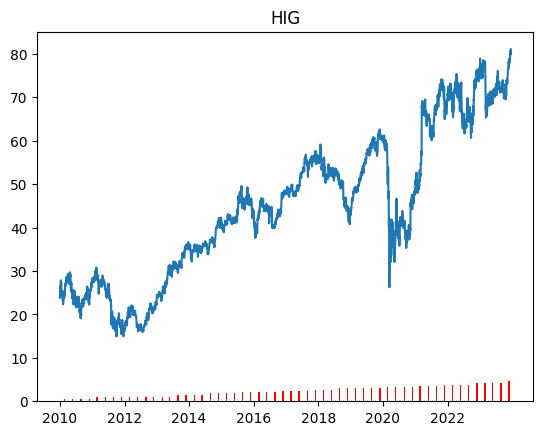

In [82]:
price_data = pd.read_csv("HIG_price.csv")
div_data = pd.read_csv("HIG_dividends.csv")
plt.plot(price_data['Date'], price_data['Close'])
plt.bar(div_data['ExDate'], div_data['Amount'].values * 10, color = 'red', width = 10)
plt.xticks([0,504,1006, 1510, 2013, 2516, 3021], [2010, 2012, 2014, 2016, 2018, 2020, 2022])
plt.title('HIG')
plt.show()

### [b] - Optimal Purchase timing validation

#### 1.  Calculating Average Returns

In [83]:
Average_return = []
for i in range(-9,11,1):
   R_i = 0
   for date in div_data['ExDate']:
      #Code for if you wanted to go 9 ACTUAL DAYS
      #date_data = datetime.strptime(date, '%Y-%m-%d') + timedelta(days = i)
      #day_before = datetime.strptime(date, '%Y-%m-%d') + timedelta(days = i - 1)
      #date_data = str(date_data)[0:10]
      #day_before = str(day_before)[0:10]
      #print(price_data.loc[price_data['Date'] == day_before]['Close'].values)
      #print(price_data.loc[price_data['Date'] == date_data]['Close'].values)
      
      #Code for 9 TRADING days back
      day = price_data.index[price_data['Date'] == date][0] + i
      day_before = price_data.index[price_data['Date'] == date][0] + (i - 1)
      #Adding dividend on ex-dividend date
      if i == 0:
         div = div_data.loc[div_data['ExDate'] == date]['Amount'].values[0]
         R_i += (price_data['Close'][day] + div)/price_data['Close'][day_before] - 1
      else:
         R_i += price_data['Close'][day]/price_data['Close'][day_before] - 1
   R_i = R_i/len(div_data['ExDate'])
   Average_return.append(R_i)
returns = pd.DataFrame({'t': np.arange(-9,11,1), 'R_t': Average_return})
returns

,t,R_t
0,-9,0.000985
1,-8,-0.003858
2,-7,-0.002932
3,-6,-0.000738
4,-5,0.001174
5,-4,0.001162
6,-3,-0.002942
7,-2,0.000747
8,-1,0.004723
9,0,0.000514


#### 2. Producing plot of Performance Index relative to Trading Days

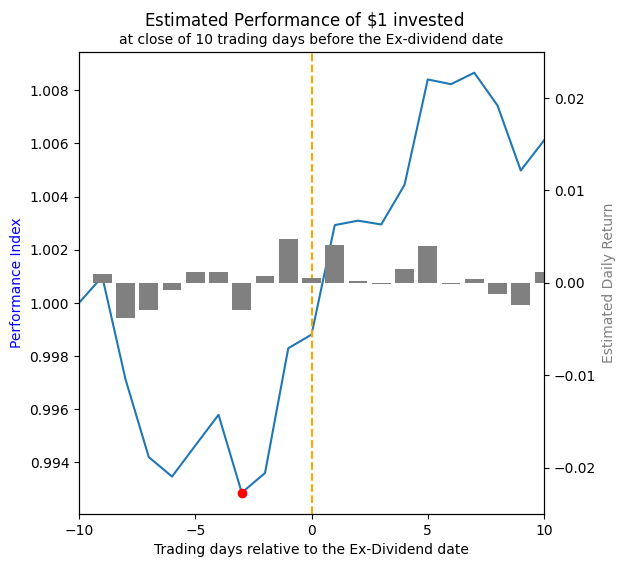

In [84]:
fig, ax = plt.subplots(figsize = (6,6))

#setting cumulative returns and adding trading day -10
returns_modify = returns.copy()
returns_modify['R_t'] = returns_modify['R_t'] + 1
trading_days = np.insert(returns_modify['t'].values, 0, -10)
cum_returns = np.insert(np.cumprod(returns_modify['R_t'].values), 0, 1)
#find minimum
min_day = trading_days[np.argmin(cum_returns)]
min_returns = np.min(cum_returns)

#plotting
ax.plot(trading_days, cum_returns)
ax.scatter(min_day, min_returns, color = 'red', zorder = 2)
ax.axvline(x = 0, color = 'orange', linestyle = 'dashed')
ax.set_xticks([-10, -5, 0, 5, 10])
ax.set_xlim([-10,10])
ax.set_ylabel('Performance Index', color = 'blue')
ax.set_xlabel('Trading days relative to the Ex-Dividend date')

ax2 = ax.twinx()
ax2.bar(returns_modify['t'], height = returns['R_t'], color = 'gray')
ax2.set_ylim([-.025, .025])
ax2.set_ylabel('Estimated Daily Return', color = 'gray')
plt.suptitle("Estimated Performance of $\$$1 invested", y = 0.95)
ax.set_title("at close of 10 trading days before the Ex-dividend date", fontsize = 10)
plt.show()

## Part B - Insurance

### [a] - Working with a Subset of data

In [85]:
cardata = pd.read_csv('vehicle_claims.csv')
cardata['Sex'] = pd.Categorical(cardata['Sex'])
cardata['VehicleType'] = pd.Categorical(cardata['VehicleType'])

In [86]:
#Get automobile data where only men and women listed
auto_data = cardata.loc[cardata['VehicleType']=='A']
men_auto = auto_data.loc[cardata['Sex'] == 'M']
women_auto = auto_data.loc[cardata['Sex'] == 'F']

In [87]:
##Claims per age category
claim_men_age = men_auto.groupby('AgeCat').apply(lambda x:\
                 np.sum(x['Claims'])/np.sum(x['Term'])).values

claim_women_age = women_auto.groupby('AgeCat').apply(lambda x:\
                 np.sum(x['Claims'])/np.sum(x['Term'])).values


results = pd.DataFrame({'Age Category':['22-25','26-35','36-45','46-55','56-65','66 and older'],\
                        'AgeCat': np.sort(men_auto['AgeCat'].unique()),\
                        'F': claim_women_age, 'M': claim_men_age})
results

,Age Category,AgeCat,F,M
0,22-25,2,0.202879,0.164333
1,26-35,3,0.191234,0.167170
2,36-45,4,0.088606,0.154696
3,46-55,5,0.104529,0.123033
4,56-65,6,0.069918,0.229789
5,66 and older,7,0.000000,0.265347


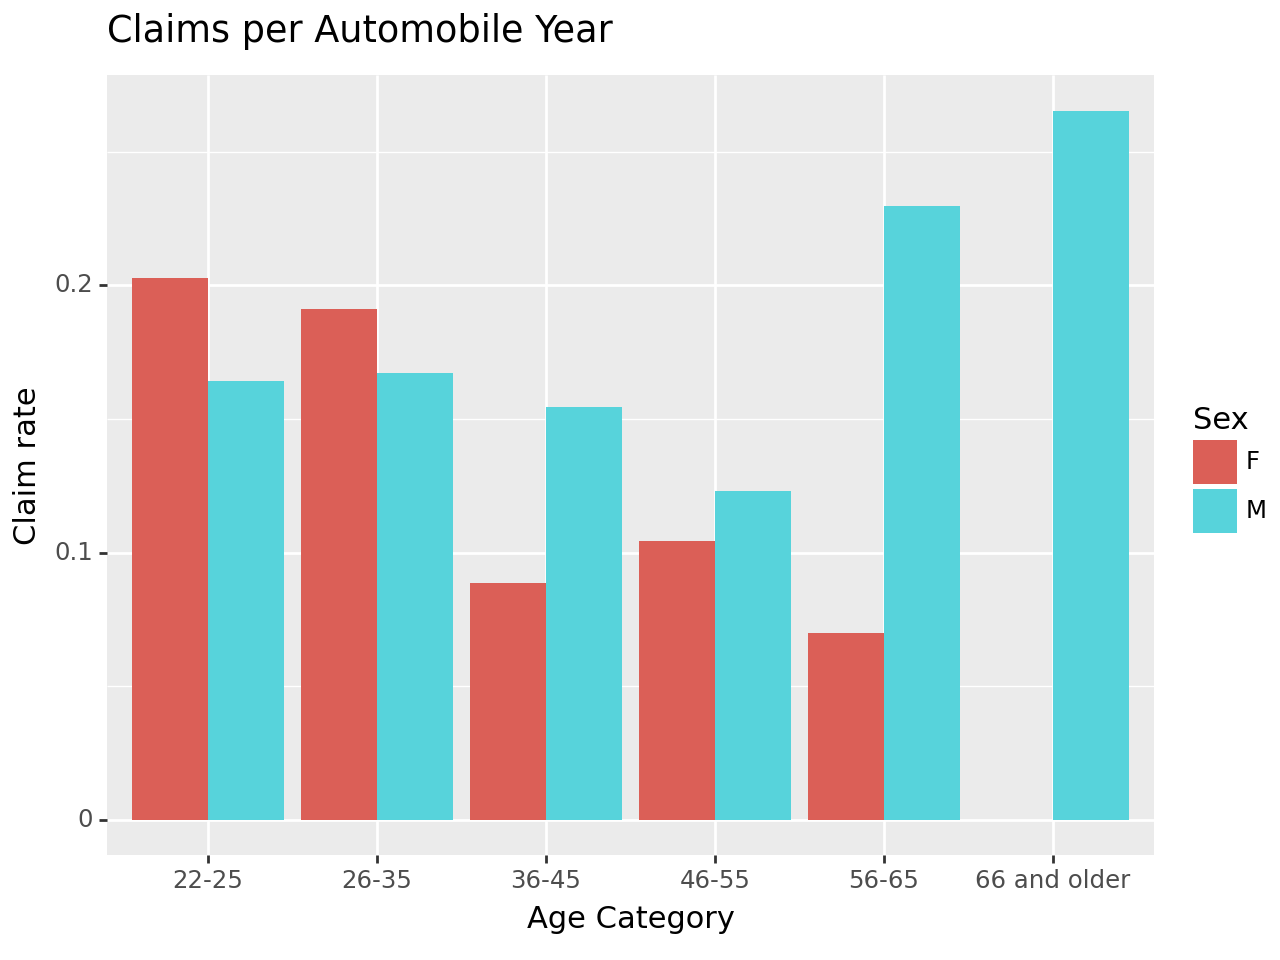

In [88]:
## Plotting in plotnine
meltframe = pd.melt(results, id_vars = ['Age Category'], value_vars = ['F', 'M'], \
                    var_name = 'Sex', value_name = 'Claim rate')
matplot = pn.ggplot(meltframe, mapping = pn.aes(x = 'Age Category',  y = 'Claim rate', fill = 'Sex')) +\
        pn.geom_bar(stat = 'identity', position = 'dodge') +\
        pn.labels.ggtitle('Claims per Automobile Year')
print(matplot)

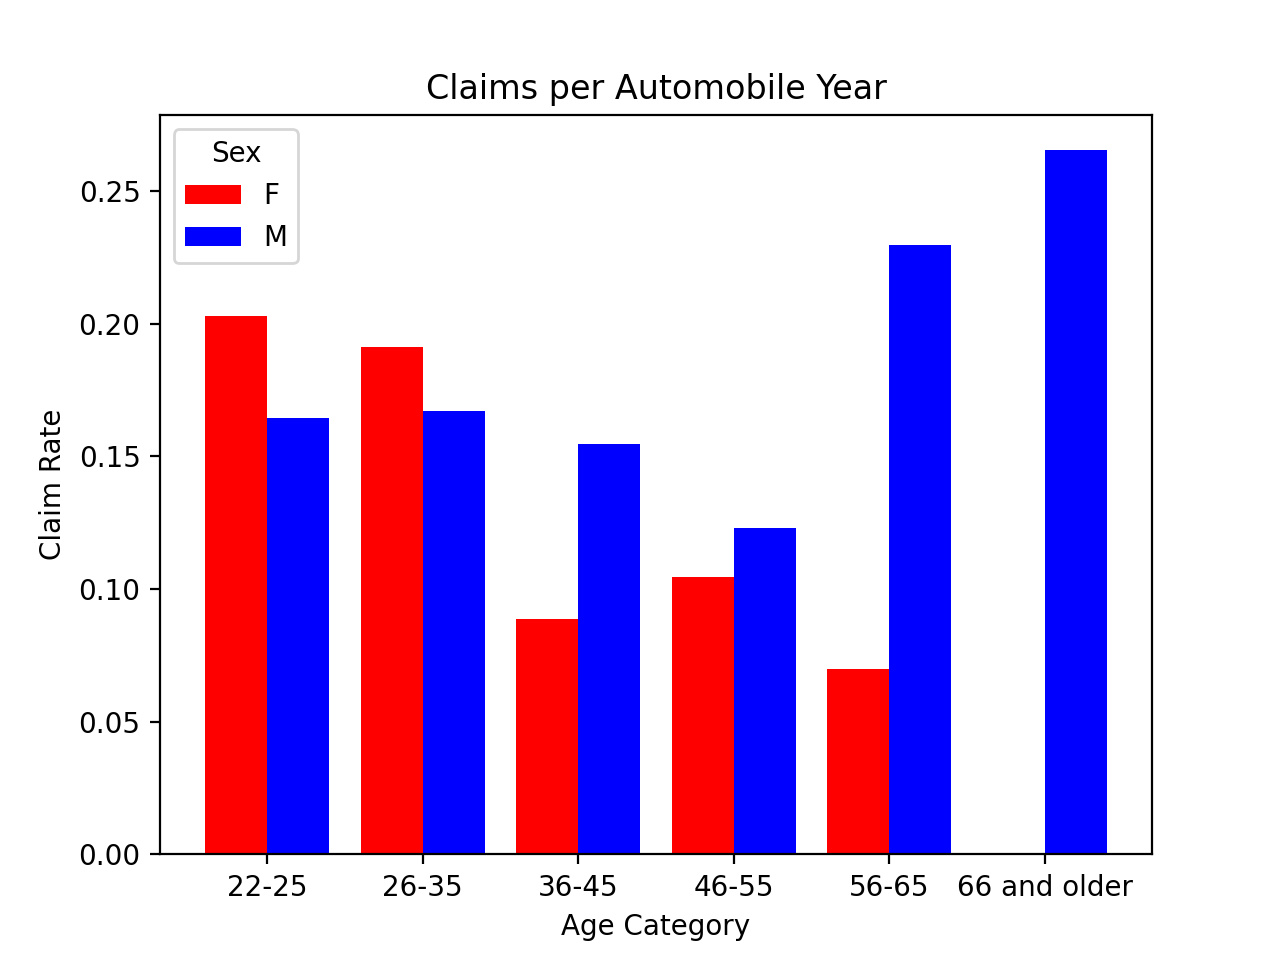

In [89]:
#Now in matplotlib
indices = np.arange(len(auto_data['AgeCat'].unique()))
width = 0.4

#plt.figure(figsize = (12,6))

plt.bar(indices, results['F'], width, label = 'F', color = 'red')
plt.bar(indices + width, results['M'], width, label = 'M', color = 'blue')
plt.xticks(indices + width / 2, results['Age Category'])

plt.legend(title = 'Sex')
plt.xlabel('Age Category')
plt.ylabel('Claim Rate')
plt.title('Claims per Automobile Year')
plt.show()

### part [b] - Regression on Full Data

In [90]:
#Create discount cat level
Discount_cat_1 = (cardata['Discount'] > 0).replace({True: 1, False: 0}).values
Discount_cat_2 = (cardata['Discount'] > 30).replace({True: 1, False: 0}).values

cardata['DiscountCat'] = Discount_cat_1 + Discount_cat_2

#Set variables to regress over as categorical
cardata['DiscountCat'] = pd.Categorical(cardata['DiscountCat'])
cardata['VehicleAgeCat'] = pd.Categorical(cardata['VehicleAgeCat'])

In [91]:
#Regression model, setting proper reference levels
reg_model = smf.poisson("Claims ~ C(DiscountCat, Treatment(reference=2)) + C(VehicleAgeCat, Treatment(reference=6))",\
                        exposure = cardata['Term'], data = cardata).fit()
print(reg_model.summary())

Optimization terminated successfully.
         Current function value: 0.241059
         Iterations 6
                          Poisson Regression Results                          
Dep. Variable:                 Claims   No. Observations:                 7483
Model:                        Poisson   Df Residuals:                     7476
Method:                           MLE   Df Model:                            6
Date:                Tue, 26 Dec 2023   Pseudo R-squ.:                 0.02811
Time:                        15:46:46   Log-Likelihood:                -1803.8
converged:                       True   LL-Null:                       -1856.0
Covariance Type:            nonrobust   LLR p-value:                 3.114e-20
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
Intercept                             

In [92]:
##Finding predictions for claim frequency
predictions = reg_model.predict(cardata[['DiscountCat', 'VehicleAgeCat']]).values

## getting observed claim frequency
observed_claim_freqency = (cardata['Claims']/cardata['Term']).values

## Calculate overdispersion multiplier
multiplier = np.matmul((predictions - observed_claim_freqency).T, predictions - observed_claim_freqency)
multiplier = multiplier/np.sum(predictions)
print("Overdispersion Multiplier: {}".format(multiplier))

Overdispersion Multiplier: 3.6803558301510777
